This notebook uses ChemPlot, which is only compatible with Python 3.9 (or older)

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

from parity import parity_plot

Had to manually open CombiSolvH-Exp and CombiSolv-Exp and export as CSV since they are malformed.

In [2]:
solute_smiles = []
solvent_smiles = []
for training_set in (
    Path("../data/SolProp_v1.2/Data/AqueousSolu.csv"),
    Path("../data/SolProp_v1.2/Data/CombiSolv-Exp.csv"),
    Path("../data/SolProp_v1.2/Data/CombiSolv-QM.txt"),
    Path("../data/SolProp_v1.2/Data/CombiSolvH-Exp.csv"),
    Path("../data/SolProp_v1.2/Data/CombiSolvH-QM.txt"),
):
    if training_set.suffix == "xlsx":
        df = pd.read_excel(training_set)
    else:
        df = pd.read_csv(training_set)
    if "Aqueous" in training_set.name:
        solute_smiles.extend(df['smiles solute'])
    elif "QM" in training_set.name:
        solute_smiles.extend(df['smiles solute'])
        solvent_smiles.extend(df['smiles solvent'])
    else:
        solute_smiles.extend(df['smiles_solute'])
        solvent_smiles.extend(df['smiles_solvent'])

# cast to set twice - once to remove immediate dupes, again to remove
# multiple identical representations
solvent_smiles = set(Chem.CanonSmiles(s) for s in set(solvent_smiles))
solute_smiles = set(Chem.CanonSmiles(s) for s in set(solute_smiles))
print(f"Training data includes {len(solvent_smiles):d} solvents and {len(solute_smiles):d} solutes.")

[15:47:31] WARNING: not removing hydrogen atom without neighbors


Training data includes 1536 solvents and 20486 solutes.


In [3]:
df = pd.read_csv(Path("../data/vermeire/solprop_nonaq.csv"), index_col=0)
testing_solutes = set(Chem.CanonSmiles(s) for s in df["solute_smiles"])
testing_solvents = set(Chem.CanonSmiles(s) for s in df["solvent_smiles"])
print(f"Testing data includes {len(testing_solvents):d} solvents and {len(testing_solutes):d} solutes.")

Testing data includes 97 solvents and 99 solutes.


In [4]:
overlapping_solutes = testing_solutes.intersection(solute_smiles)
overlapping_solvents = testing_solvents.intersection(solvent_smiles)
print(f"Overlap of train and test solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(testing_solutes):.2%} of test set.")
print(f"Overlap of train and test solvents is {len(overlapping_solvents):d}, or {len(overlapping_solvents)/len(testing_solvents):.2%} of test set.")

Overlap of train and test solutes is 76, or 76.77% of test set.
Overlap of train and test solvents is 95, or 97.94% of test set.


In [5]:
test_only_solutes = list(filter(lambda s: s not in overlapping_solutes, testing_solutes))
rng = np.random.default_rng(seed=2)
train_only_solutes = rng.choice(list(filter(lambda s: s not in overlapping_solutes, solute_smiles)), 200, replace=False, shuffle=False)

In [6]:
combined_solute_list = list(overlapping_solutes) + list(train_only_solutes) + list(test_only_solutes)
combined_origin_list = ["Overlapping"] * len(overlapping_solutes) + ["Train Only"] * len(train_only_solutes) + ["Test Only"] * len(test_only_solutes)

In [7]:
from chemplot import Plotter

/home/jackson/miniconda3/envs/fastsolv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
pltr = Plotter.from_smiles(combined_solute_list, target=combined_origin_list, target_type="C")

sim_type indicates the similarity type by which the plots are constructed.
The supported similarity types are structural and tailored.
Because a target list has been provided 'tailored' as been selected as sym_type.


In [9]:
pltr.tsne()

,t-SNE-1,t-SNE-2,target
0,-6.620735,-27.490881,Overlapping
1,-12.324514,0.926963,Overlapping
2,45.890270,8.423779,Overlapping
3,8.700309,20.617321,Overlapping
4,-15.839197,-0.394819,Overlapping
...,...,...,...
294,18.194275,37.230476,Test Only
295,13.431891,-8.255558,Test Only
296,17.783396,-25.802389,Test Only
297,-29.860655,-0.368022,Test Only


<AxesSubplot:label='scatter', title={'center':'SolProp Training vs. Testing Data'}, xlabel='t-SNE-1', ylabel='t-SNE-2'>

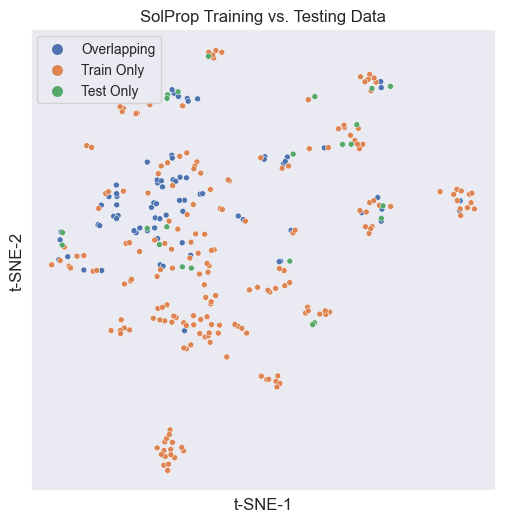

In [10]:
pltr.visualize_plot(size=6, remove_outliers=True, title="SolProp Training vs. Testing Data")